In [114]:
import numpy as np
from numpy import mean, std, dstack
from pandas import read_csv
from matplotlib import pyplot as plt, pyplot

import keras
from keras.layers import LSTM
from tensorflow.keras.layers import Activation, MaxPooling1D, Dense, Input, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Flatten, BatchNormalization, concatenate
from keras.utils import to_categorical, plot_model
from tensorflow.keras import optimizers
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# set seed to reproduce similar results
np.random.seed(0)

In [115]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'C:/ex1/uard/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'C:/ex1/uard/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [116]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [117]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

(470528, 9)


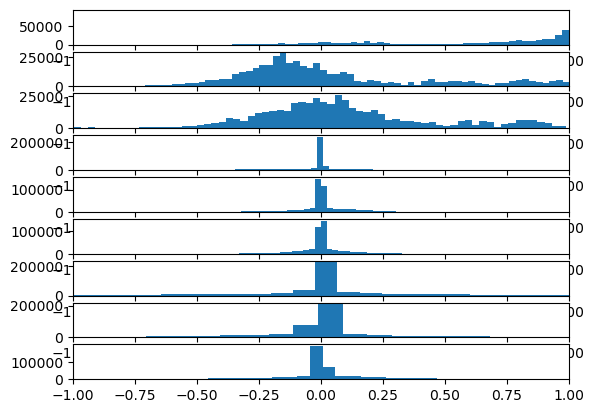

In [118]:
# plot distributions
plot_distributions(trainX)

In [119]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [120]:
from keras.layers import Bidirectional, GRU
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()

model.add(Bidirectional(GRU(64))) # Bidirectional GRU를 사용
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [121]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)


Epoch 1/10
92/92 [==============================] - 16s 116ms/step - loss: 1.2835 - accuracy: 0.4708 - val_loss: 1.1190 - val_accuracy: 0.5636
Epoch 2/10
92/92 [==============================] - 9s 102ms/step - loss: 0.8729 - accuracy: 0.6416 - val_loss: 0.7751 - val_accuracy: 0.7084
Epoch 3/10
92/92 [==============================] - 9s 103ms/step - loss: 0.5333 - accuracy: 0.7965 - val_loss: 0.4298 - val_accuracy: 0.8634
Epoch 4/10
92/92 [==============================] - 10s 105ms/step - loss: 0.3151 - accuracy: 0.8871 - val_loss: 0.3602 - val_accuracy: 0.8994
Epoch 5/10
92/92 [==============================] - 10s 104ms/step - loss: 0.2437 - accuracy: 0.9131 - val_loss: 0.2968 - val_accuracy: 0.9096
Epoch 6/10
92/92 [==============================] - 10s 105ms/step - loss: 0.3068 - accuracy: 0.8907 - val_loss: 0.3865 - val_accuracy: 0.8586
Epoch 7/10
92/92 [==============================] - 9s 102ms/step - loss: 0.2697 - accuracy: 0.9112 - val_loss: 0.2407 - val_accuracy: 0.9137
Ep

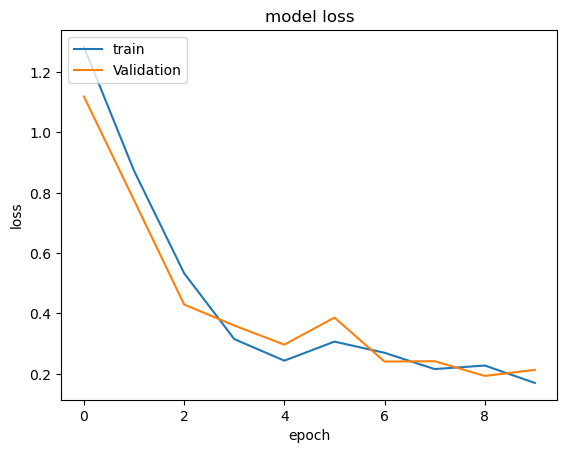

In [122]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [123]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the GRU model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the GRU model 0.8758059144020081
93/93 [==============================] - 3s 19ms/step


In [124]:
predictions

array([[9.6308035e-01, 2.8860793e-03, 1.5597431e-03, 2.4300351e-05,
        3.2449417e-02, 8.1890391e-08],
       [1.7151384e-03, 1.0624394e-04, 1.4161212e-05, 1.9386606e-02,
        9.7877729e-01, 5.6342810e-07],
       [1.9538272e-03, 1.1570249e-04, 1.4694721e-05, 1.8301958e-02,
        9.7961318e-01, 6.2077487e-07],
       ...,
       [6.1319990e-04, 9.9931216e-01, 3.4039506e-06, 2.1763481e-06,
        3.0090872e-05, 3.9048104e-05],
       [1.4744748e-03, 9.9753833e-01, 1.4449950e-05, 4.3062631e-05,
        3.5691771e-04, 5.7278416e-04],
       [7.6150231e-04, 9.9915147e-01, 2.0971371e-05, 8.3466051e-07,
        8.9451223e-06, 5.6274723e-05]], dtype=float32)

**** Confusion Matrix ****
[[462   1  30   0   3   0]
 [ 55 384  31   0   1   0]
 [ 14   0 406   0   0   0]
 [  0  10   0 419  61   1]
 [ 21   1   0 119 391   0]
 [  0  18   0   0   0 519]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.84      0.93      0.88       496
           2       0.93      0.82      0.87       471
           3       0.87      0.97      0.92       420
           4       0.78      0.85      0.81       491
           5       0.86      0.73      0.79       532
           6       1.00      0.97      0.98       537

    accuracy                           0.88      2947
   macro avg       0.88      0.88      0.88      2947
weighted avg       0.88      0.88      0.88      2947



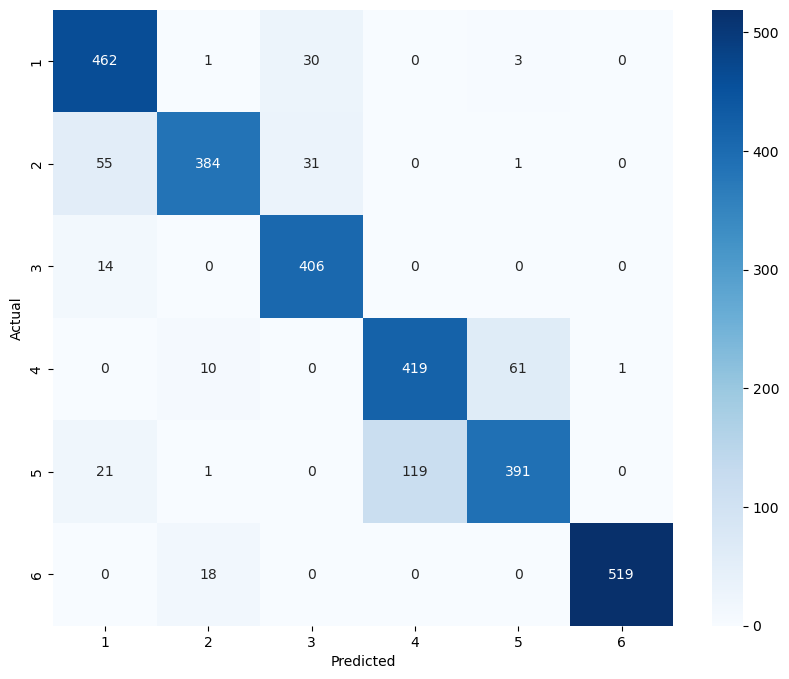

In [125]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

In [126]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
from keras.layers import LSTM

model = Sequential()
model.add(GRU(64, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [127]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
train_epochs = 20
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)


Epoch 1/20
92/92 [==============================] - 9s 75ms/step - loss: 1.3376 - accuracy: 0.4543 - val_loss: 1.1302 - val_accuracy: 0.5438
Epoch 2/20
92/92 [==============================] - 6s 68ms/step - loss: 0.9894 - accuracy: 0.5701 - val_loss: 0.9606 - val_accuracy: 0.6268
Epoch 3/20
92/92 [==============================] - 6s 70ms/step - loss: 0.7527 - accuracy: 0.6616 - val_loss: 0.6938 - val_accuracy: 0.6785
Epoch 4/20
92/92 [==============================] - 6s 70ms/step - loss: 0.6243 - accuracy: 0.7058 - val_loss: 0.5922 - val_accuracy: 0.7750
Epoch 5/20
92/92 [==============================] - 6s 68ms/step - loss: 0.5189 - accuracy: 0.7745 - val_loss: 0.4749 - val_accuracy: 0.8491
Epoch 6/20
92/92 [==============================] - 6s 70ms/step - loss: 0.3826 - accuracy: 0.8507 - val_loss: 0.2964 - val_accuracy: 0.8851
Epoch 7/20
92/92 [==============================] - 7s 72ms/step - loss: 0.2421 - accuracy: 0.9180 - val_loss: 0.3236 - val_accuracy: 0.8736
Epoch 8/20
92

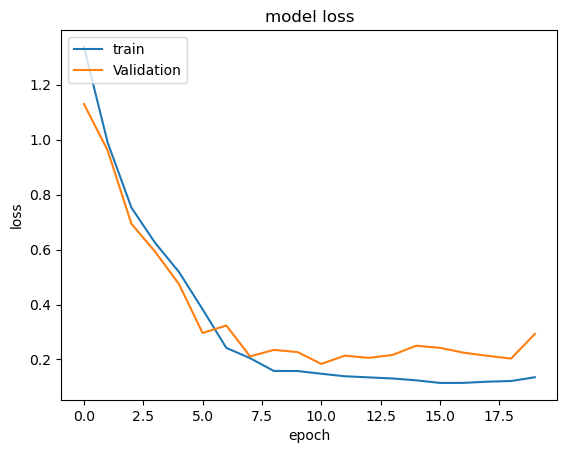

In [128]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [129]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(testX)

Accuracy of the CNN model 0.9066847562789917
93/93 [==============================] - 2s 19ms/step


**** Confusion Matrix ****
[[437  46  13   0   0   0]
 [  5 466   0   0   0   0]
 [  0   5 415   0   0   0]
 [  5   2   1 372 111   0]
 [  6   0   0  53 473   0]
 [  0  26   1   1   0 509]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.96      0.88      0.92       496
           2       0.86      0.99      0.92       471
           3       0.97      0.99      0.98       420
           4       0.87      0.76      0.81       491
           5       0.81      0.89      0.85       532
           6       1.00      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



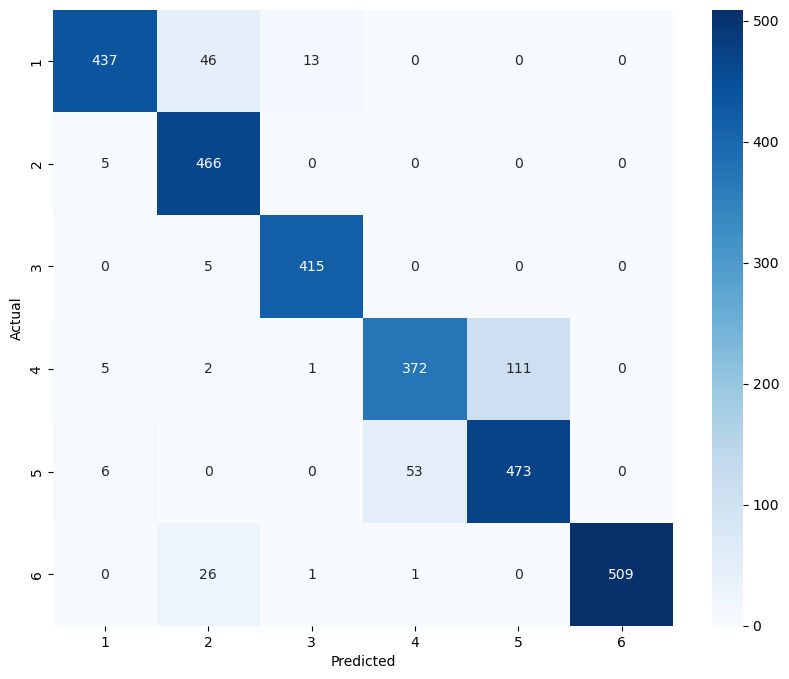

In [130]:
display_results(testy,predictions,classNames)